**{DEV}\[TODO\]**
- Explain rel vs abs more detailed
- Check if anything relevant to be said specifically for double pendulum
- Same as above but for n-link
- Proofread

---
### Chapter 1: System Modelling
---
# **Tutorial 1.c: Relative vs Absolute Orientations**
**Aim:** To compare the performance of simulation when using relative vs absolute orientations

Previously, we simulated a double pendulum swinging, both freely and with non-conservative forces. Now we're going to add links to the pendulum and show the performance slow-down in both relative and absolute orientations.

### **Contents**:
* [Relative vs Aboslute Orientations](#Relative-vs-Absolute-Orientations)
* [Double Pendulum](#Double-Pendulum)
* [n-Link Pendulum](#n-Link-Pendulum)

## **Relative vs Absolute Orientations**

**Further reading:** A. Knemeyer, S. Shield, and A. Patel, “Minor Change, Major Gains: The Effect of Orientation Formulation on Solving Time for Multi-Body Trajectory Optimization,” IEEE Robotics and Automation Letters, vol. 5, no. 4, pp. 5331–5338, Jul. 2020, doi: https://doi.org/10.1109/lra.2020.3007410.

In tutorial 1, we spoke about different coordinate spaces (namely, the system space and joint space). To recap:
- **System Space** - maximal coordinate system, describing the position and orientation of each link _absolutely_ (relative to the world frame)
- **Joint Space** - coordinate system that describes the position and orientation of each link relative to its parent link

It is easier to express locations in the joint space, as we do not need to explicitly define constraint forces at the joints. It also has better performance than expressing locations in system space coordinates (this is tested in the paper linked above, but we will not be testing it here). However, a minor change we can make from the joint space expressions we've been using so far is to instead use a hybrid system--relative positions, but absolute orientations.

Why does this matter? When using relative orientations, the angle of each link depends not only on the angle of the joint it originates from, but on **all** the joint angles before it. This causes the equations of motion to become quite complicated and slow to compute. 

## **Double Pendulum**

To compare the performance differences, let's use the double pendulum established in the previous two tutorials.

In [1]:
# import libraries
import sympy as sym
import numpy as np
import time # for benchmarking different models

from IPython.display import display, HTML #for pretty printing
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 32em; }</style>"))

# define time-logging function for benchmarking
def log_time(t_start=None, msg=""):
    t_end = time.perf_counter()
    if t_start == None:
        if msg == "": print("Timer initialized")
        else: print(msg)
    else: print(msg + f": {t_end - t_start:.6f} sec")
    return t_end

In [2]:
# CODE FROM LAST TIME

# create symbolic variables

# system parameters
g = sym.symbols('g')
m1 ,  m2 = sym.symbols([ 'm_{1}', 'm_{2}']) # mass of links
l1 ,  l2 = sym.symbols([ 'l_{1}', 'l_{2}']) # length of links
d1 ,  d2 = sym.symbols([ 'd_{1}', 'd_{2}']) # distance to COM (as a fraction)
In1, In2 = sym.symbols(['In_{1}','In_{2}']) # moment of intertia of links

# generalized coordinates
X0, Y0 = sym.symbols(['X_{0}','Y_{0}']) # fixed position of first link

th1  ,  th2 = sym.symbols([       '\\theta_{1}',       '\\theta_{2}']) #positions
dth1 , dth2 = sym.symbols([ '\dot{\\theta}_{1}', '\dot{\\theta}_{2}']) #velocities
ddth1,ddth2 = sym.symbols(['\ddot{\\theta}_{1}','\ddot{\\theta}_{2}']) #accelerations

q   = sym.Matrix([  [th1],  [th2]]) #group into matrices
dq  = sym.Matrix([ [dth1], [dth2]])
ddq = sym.Matrix([[ddth1],[ddth2]])

# STEP 1: system space coordinates written in terms of the generalised coordinates

# helper functions
def Rotate(v, th):
    # the 2D system space coordinates are [x;y;th], so we need a rotation function that can work with this
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                    [          0,            0, 1]]) # rotation matrix, augmented because of the theta element of the vector
    S = sym.Matrix([[0],[0],[th]]) # angle of rotation
    return R*v + S # coordinates after rotation

def GetXY(v):
    # this function is for applying a position-only offset (preserves the angle)
    vector_mask = sym.Matrix([[1],[1],[0]]) # gets rid of angle component of vector when multiplied elementwise
    return v.multiply_elementwise(vector_mask)

# positions of each link in their own reference frames
r0 = sym.Matrix([[X0],[Y0],[0]])
r1_1 = sym.Matrix([[0],[-d1*l1],[0]])
r2_2 = sym.Matrix([[0],[-d2*l2],[0]])

#### **Differences in Coding—Relative vs Absolute Orientations**

In [3]:
# Relative orientations (what we've been doing so far)

# positions of each link, moved into the inertial frame
r1_0 = Rotate(r1_1, th1) + GetXY(r0)

r2_1 = Rotate(r2_2, th2) + GetXY(r1_1/d1*(1-d1))
r2_0 = Rotate(r2_1, th1) + GetXY(r1_0)

# end position in force coordinates wrt generalized coordinates:
rEnd_0 = Rotate(r2_2/d2*(1-d2), th2 + th1) + GetXY(r2_0) #<- the first term is because r2_2 is at the midpoint of the link and we want the end

In [4]:
# Absolute orientations

# positions of each link, moved into the inertial frame
r1_0 = Rotate(r1_1, th1) + GetXY(r0)

r2_1 = Rotate(r2_2, th2-th1) + GetXY(r1_1/d1*(1-d1)) # <- this changes
r2_0 = Rotate(r2_1, th1) + GetXY(r1_0) # <- and this too, if there were more links (but it would still be a two-liner)

# end position in force coordinates wrt generalized coordinates:
rEnd_0 = Rotate(r2_2/d2*(1-d2), th2) + GetXY(r2_0) # <- this changes too

**NOTE:** Changing between relative and absolute orientations is that easy. You don't need to change anything else—the rest of the code below inherits the changes since they are calculated using the r values.

In [5]:
# CODE FROM LAST TIME

# STEP 2: generate expressions for the system space velocities

dr1 = r1_0.jacobian(q)*dq
dr2 = r2_0.jacobian(q)*dq

# STEP 3: generate expressions for the kinetic and potential energy

# helper functions
def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

# expressions
T = Ek(m1, In1, dr1) + Ek(m2, In2, dr2)
V = Ep(m1, r1_0) + Ep(m2, r2_0)

#--------------------------------------------------------------------------------------------------

# STEP 4: calculate each term of the Lagrange equation

# term 1
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 2 = 0
# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

# STEP 5: calculate generalized forces

# -----------------------------------------------------------------------------------

# arbitrary force
Fx, Fy = sym.symbols(['F_{x}','F_{y}'])
FF = sym.Matrix([[Fx],[Fy],[0]])

# the jacobian
JF = rEnd_0.jacobian(q)

# generalized force
QF = JF.T * FF # <- something.T is a shortcut for something.transpose()

# -----------------------------------------------------------------------------------

# arbitrary control torque
tau = sym.symbols('tau')
Qtau = sym.Matrix([[0],[tau]]) # <- no need for coordinate translation

# -----------------------------------------------------------------------------------

# STEP 6: put it all together

Qtot = QF + Qtau

EOM = Lg1 - Lg3 + Lg4 - Qtot.T
EOM = EOM.T

# display(EOM)

In [6]:
# IF THIS CELL IS TOO SLOW, YOU DON'T NEED TO RUN IT

start_time = log_time()
EOM = sym.trigsimp(EOM)
current_time = log_time(start_time, "EOM simplified")

Timer initialized
EOM simplified: 18.287321 sec


The above cell simplifies the EOMs to speed up the simulation. You can run the simulation both with and without having run the simplification to test the performance difference. 

In [7]:
# simulation, with timers printing how long it took.
# run this with after running the above cells using relative orientations, then again using absolute orientations.

start_time = log_time()

N = 100
h = 0.01
t = np.arange(0,N*h,h)

#parameters
X0val, Y0val  = 0  , 2
l1val, l2val  = 1  , 1
d1val, d2val  = 0.5, 0.5

# --------------------------------------------------------------------------------

# forces
Fy_val = 0;

# try both options!

# force but no torque - Option A
Fx_val = 5*np.sin(8*np.pi*t)
tau_val = np.zeros(np.shape(t));

# # torque but no force - Option B
# Fx_val = np.zeros(np.shape(t));
# tau_val = 5*np.sin(8*np.pi*t)

# --------------------------------------------------------------------------------

parameter_values = [(X0,X0val),(Y0,Y0val),
                    (g,9.81),
                    (m1,1),(m2,1),
                    (l1,l1val),(l2,l2val),
                    (d1,d1val),(d2,d2val),
                    (In1,0.08),(In2,0.08),
                    (Fy,Fy_val)] # since we aren't using Fy, subs here to make loop faster

# substitute parameters into EOM
EOM_sub_params = EOM.subs(parameter_values)

#initial conditions
th1vals  = [0]
th2vals  = [0]
dth1vals = [0]
dth2vals = [0]

for i in range(1,N+1):
    # conditions at previous timestep
    prev = [( th1,  th1vals[i-1]),
            ( th2,  th2vals[i-1]),
            (dth1, dth1vals[i-1]),
            (dth2, dth2vals[i-1])]
    
    # force and torque values
    forces = [(Fx,Fx_val[i-1]),(tau,tau_val[i-1])]
    
    # substitute previous conditions into EOM
    EOM_sub = EOM_sub_params.subs(prev).subs(forces)
    
    # solve for the acceleration
    accel = sym.solve(EOM_sub,[ddth1, ddth2])
    
    # integrate for the next velocity  
    dth1vals.append(float(dth1vals[i-1] + h * accel[ddth1]))
    dth2vals.append(float(dth2vals[i-1] + h * accel[ddth2]))
    
    # integrate for the next position
    th1vals.append(float(th1vals[i-1] + h * dth1vals[i]))
    th2vals.append(float(th2vals[i-1] + h * dth2vals[i]))
    
    print('\r%s' %i ,end='') # <- so you know how far into the simulation you are
    
current_time = log_time(start_time, "\rSimulation Complete")

Timer initialized
Simulation Complete: 11.239799 sec


## **n-Link Pendulum**

The code below maintains the general structure set out above and in previous tutorials. However, it may appear unfamiliar due to the way it was generalized for n links.

In [8]:
def benchmark_model(nlinks,orientation,timesteps):

    # print output so we can keep track of where the program is
    if orientation == 'rel': msg = "Relative Orientations"
    else: msg = "Absolute Orientations"
    msg += ": %s links" %nlinks

    start_time = log_time(msg=msg)
    
    # --------------------------------------------------------------------------------------------------------------
    
    # create symbolic variables - Generalized for n-link
    links = np.arange(nlinks)
    
    # system parameters
    g = sym.symbols('g')

    m  = [sym.symbols( 'm_{%s}' %i) for i in links] # mass of links
    l  = [sym.symbols( 'l_{%s}' %i) for i in links] # length of links
    d  = [sym.symbols( 'd_{%s}' %i) for i in links] # distance to COM (as a fraction)
    In = [sym.symbols('In_{%s}' %i) for i in links] # moment of intertia of links

    # generalized coordinates
    X0, Y0 = sym.symbols(['X_{0}','Y_{0}']) # fixed position of first link

    th   = [sym.symbols(       '\\theta_{%s}' %i) for i in links] #positions
    dth  = [sym.symbols( '\dot{\\theta}_{%s}' %i) for i in links] #velocities
    ddth = [sym.symbols('\ddot{\\theta}_{%s}' %i) for i in links] #accelerations

    q   = sym.Matrix([  th[i] for i in links]) #group into matrices
    dq  = sym.Matrix([ dth[i] for i in links])
    ddq = sym.Matrix([ddth[i] for i in links])
    
    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 1: system space coordinates written in terms of the generalised coordinates

    # helper functions
    def Rotate(v, th):
        # the 2D system space coordinates are [x;y;th], so we need a rotation function that can work with this
        R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                        [sym.sin(th),  sym.cos(th), 0],
                        [          0,            0, 1]]) # rotation matrix, augmented because of the theta element of the vector
        S = sym.Matrix([[0],[0],[th]]) # angle of rotation
        return R*v + S # coordinates after rotation

    def GetXY(v):
        # this function is for applying a position-only offset (preserves the angle)
        vector_mask = sym.Matrix([[1],[1],[0]]) # gets rid of angle component of vector when multiplied elementwise
        return v.multiply_elementwise(vector_mask)

    # positions of each link in their own reference frames
    r0 = sym.Matrix([[X0],[Y0],[0]])
    rn_n = [sym.Matrix([[0],[-d[i]*l[i]],[0]]) for i in links]
    rn_0 = []

    for i,r in enumerate(rn_n): # enumerate returns the index and the value at that index
        if i == 0: # hopefully i'm the only person who i confused by forgetting python is 0 indexed.
            rn_0.append( Rotate(r, th[i]) + GetXY(r0) ) # r1_0 = blah blah
        else:
            if orientation == 'rel':
                rn_m = Rotate(r, th[i]) + GetXY(rn_n[i-1]/d[i-1]*(1-d[i-1]))
                thm_0 = sum([th[j] for j in range(i)]) # sum of all theta values EXCEPT the last one
                
            elif orientation == 'abs':
                rn_m = Rotate(r, th[i]-th[i-1]) + GetXY(rn_n[i-1]/d[i-1]*(1-d[i-1]))
                thm_0 = th[i-1] # just the second last theta value

            rn_0.append( Rotate(rn_m, thm_0) + GetXY(rn_0[i-1]) ) # rotate it, then add the world-frame offset from the previous link

    # end position in force coordinates wrt generalized coordinates:
    if orientation == 'rel':
        rEnd_0 = Rotate( rn_n[-1]/d[i-1]*(1-d[i-1]), sum([th[i] for i in links]) ) + GetXY(rn_0[-1])
    elif orientation == 'abs':
        rEnd_0 = Rotate( rn_n[-1]/d[i-1]*(1-d[i-1]), th[i] ) + GetXY(rn_0[-1]) # rotate remainder of link n into frame 0, add it to rn_0
    
    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 2: generate expressions for the system space velocities
    
    dr = []
    dr.extend([r.jacobian(q)*dq for r in rn_0])
        
    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 3: generate expressions for the kinetic and potential energy
    
    # helper functions
    def Ek(m, In, dr):
        InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
        return 0.5*dr.T*InM*dr

    def Ep(m, r):
        return sym.Matrix([m*g*r[1]])

    # expressions
    T = sym.Matrix([[0]])
    V = sym.Matrix([[0]])
    for i in links:
        T += Ek(m[i], In[i], dr[i])
        V += Ep(m[i], rn_0[i])
    
    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 4: calculate each term of the Lagrange equation
    
    # term 1
    Lg1 = sym.zeros(1,len(q))
    for i in range(len(q)):
        dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
        Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

    # term 2 = 0
    # term 3
    Lg3 = T.jacobian(q) # partial of T in q

    # term 4
    Lg4 = V.jacobian(q) # partial of U in q
    
    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 5: calculate generalized forces
    
    # arbitrary force
    Fx, Fy = sym.symbols(['F_{x}','F_{y}'])
    FF = sym.Matrix([[Fx],[Fy],[0]])

    # the jacobian
    JF = rEnd_0.jacobian(q)

    # generalized force
    QF = JF.T * FF

    # arbitrary control torque - this time, since we don't know how many angles we have, let's do it in a different way
    #                            doing it this way also means we don't have to change this code for relative vs absolute orientations
    tau = sym.symbols('tau')
    tau_lm = sym.Matrix([[0],[0],[-tau]]) # the world frame torque acting on the second last link
    tau_ln = sym.Matrix([[0],[0],[ tau]]) # the world frame torque acting on the last link

    if nlinks == 1:
        Qtau = rn_0[0].jacobian(q).T*tau_ln
    else:
        i,j = links[-1],links[-2] # the link numbers
        Qtau = rn_0[i].jacobian(q).T*tau_ln + rn_0[j].jacobian(q).T*tau_lm

    # --------------------------------------------------------------------------------------------------------------
    
    # STEP 6: put it all together
    
    Qtot = QF + Qtau
    
    EOM = Lg1 - Lg3 + Lg4 - Qtot.T
    EOM = EOM.T
#     EOM = sym.trigsimp(EOM) # <- COMMENT OUT THIS LINE IF IT IS TOO SLOW


    # --------------------------------------------------------------------------------------------------------------


    # SIMULATION
    
    N = timesteps
    h = 0.01
    t = np.arange(0,N*h,h)

    #parameters
    X0val, Y0val  = 0, nlinks

    # --------------------------------------------------------------------------------

    # forces
    Fy_val = 0;

    # force but no torque - Option A
    Fx_val = 5*np.sin(8*np.pi*t)
    tau_val = np.zeros(np.shape(t));

    # # torque but no force - Option B
#     Fx_val = np.zeros(np.shape(t));
#     tau_val = 5*np.sin(8*np.pi*t)

    # --------------------------------------------------------------------------------

    parameter_values = [(X0,X0val),(Y0,Y0val),(g,9.81),(Fy,Fy_val)]
    parameter_values.extend([(m[i] ,1)    for i in links])
    parameter_values.extend([(l[i] ,1)    for i in links])
    parameter_values.extend([(d[i] ,0.5)  for i in links])
    parameter_values.extend([(In[i],0.08) for i in links])

    # substitute parameters into EOM
    EOM_sub_params = EOM.subs(parameter_values)

    #initial conditions
    thvals  = np.zeros((N + 1, len(links)))
    dthvals = np.zeros((N + 1, len(links)))

    current_time = log_time(start_time, "Modelling Complete ")

    for i in range(1,N+1):
        # conditions at previous timestep
        prev = [(th[j],  thvals[i-1][j]) for j in links]
        prev.extend([(dth[j], dthvals[i-1][j]) for j in links])

        # force and torque values
        forces = [(Fx,Fx_val[i-1]),(tau,tau_val[i-1])]

        # substitute previous conditions into EOM
        EOM_sub = EOM_sub_params.subs(prev + forces)

        # solve for the acceleration
        accel = sym.solve(EOM_sub,[ddth[j] for j in links])

        # integrate for the next velocity
        dthvals[i] = dthvals[i-1] + h * np.array([accel[ddth[j]] for j in links], dtype=float)

        # integrate for the next position
        thvals[i] = thvals[i-1] + h * dthvals[i]

        print('\rSimulating, timestep = %s' %i ,end='') # <- so you know how far into the simulation you are
        
    current_time = log_time(current_time, "\rSimulation Complete")
    return current_time - start_time

**NOTE:** Simplification of the EOMs was left commented out in this example, since for longer pendulums it becomes quite time-consuming (especially for relative orientations). You can uncomment it (line 154) to observe the performance difference.

In [9]:
# import libraries
import sympy as sym
import numpy as np
import time # for benchmarking different models

from IPython.display import display, HTML #for pretty printing
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 32em; }</style>"))

# define time-logging function for benchmarking
def log_time(t_start=None, msg=""):
    t_end = time.perf_counter()
    if t_start == None:
        if msg == "": print("Timer initialized")
        else: print(msg)
    else: print(msg + f": {t_end - t_start:.6f} sec")
    return t_end


# benchmark
t_abs = []
t_rel = []
max_links = 4 # increase at your own risk (may take forever)
for i in range(1,max_links+1):
    nlinks = i
    timesteps = 100

    t_abs.append(benchmark_model(nlinks,'abs',timesteps))
    print('')
    t_rel.append(benchmark_model(nlinks,'rel',timesteps))
    
    print('')
    print('------------------------------------')
    print('')

Absolute Orientations: 1 links
Modelling Complete : 0.107607 sec
Simulation Complete: 2.830090 sec

Relative Orientations: 1 links
Modelling Complete : 0.038827 sec
Simulation Complete: 2.687477 sec

------------------------------------

Absolute Orientations: 2 links
Modelling Complete : 1.317478 sec
Simulation Complete: 18.964124 sec

Relative Orientations: 2 links
Modelling Complete : 1.378350 sec
Simulation Complete: 24.656150 sec

------------------------------------

Absolute Orientations: 3 links
Modelling Complete : 4.778415 sec
Simulation Complete: 49.263109 sec

Relative Orientations: 3 links
Modelling Complete : 7.457004 sec
Simulation Complete: 68.508853 sec

------------------------------------

Absolute Orientations: 4 links
Modelling Complete : 12.463523 sec
Simulation Complete: 103.061127 sec

Relative Orientations: 4 links
Modelling Complete : 27.940178 sec
Simulation Complete: 255.060402 sec

------------------------------------



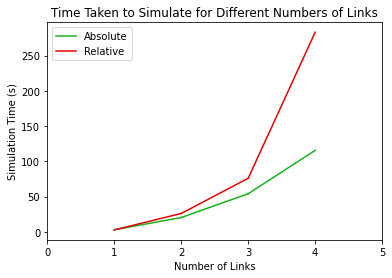

In [10]:
# Plot the performance to compare

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes

ax1.clear()   
ax1.set_xlim([0,max_links+1])
# ax1.set_ylim([0,30000])

[ax1.plot([i,i+1],[t_abs[i-1],t_abs[i]], color='xkcd:green', label="Absolute" if i == 1 else "") for i in range(1,max_links)]
[ax1.plot([i,i+1],[t_rel[i-1],t_rel[i]], color='xkcd:red'  , label="Relative" if i == 1 else "") for i in range(1,max_links)]

# green_proxy = plt.Line2D([0], [0], color='xkcd:green')
# red_proxy = plt.Line2D([0], [0], color='xkcd:red')
# ax1.legend([green_proxy, red_proxy], ['Absolute', 'Relative'])

plt.ylabel('Simulation Time (s)')
plt.xlabel('Number of Links')
plt.title("Time Taken to Simulate for Different Numbers of Links")
# plt.xticks(np.arange(N), ('M1', '', 'M2 rel', '', 'M2 abs','', 'M3 rel', '', 'M3 abs', ''))
# plt.yticks(np.arange(0, 0.8, 0.1))
plt.legend()

plt.show()